# 频率域滤波

频率域滤波的理论部分转到`傅里叶变换相关公式的推导.md`

了解了一些数学背景之后，现在来学习后续的知识。在上面的公式推导中，我们涉及到的是一维的傅里叶变换，一张图像其实可以看做是一个二维的信号，所以应该应用二维的傅里叶变换。

傅里叶变换的函数在numpy里面有提供，具体的实现方式暂且不管，下面我们感性地认识一下信号、图像以及它们在频域的样子

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

下面是一维的傅里叶变换示意图（准确地说下面显示的是功率谱图像）

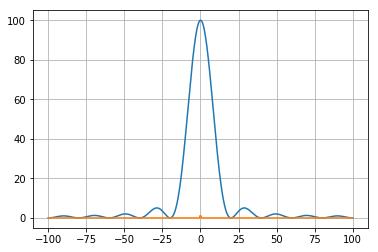

In [44]:
n = 2000
x = np.linspace(-100, 100, n)
y = np.zeros(n)
y[n // 2 - 5 : n // 2 + 5] = 1
# y = 1 / x * np.sin(x)
# plt.axis([-10, 10, -2, 2])
plt.plot(x, np.abs(np.fft.fftshift(np.fft.fft(y))) ** 2, x, y), plt.grid(True)
plt.show()

下面是二维数据的傅里叶频谱（功率谱）

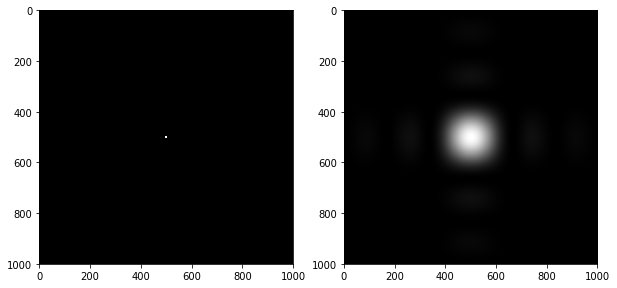

In [45]:
test = np.zeros((1000, 1000))
n = 3
center = 500
test[center - n : center + n, center - n : center + n] = 1.
ft = np.abs(np.fft.fftshift(np.fft.fft2(test))) ** 2
plt.figure(figsize = (10, 5))
plt.subplot(121), plt.imshow(test, cmap = 'gray')
plt.subplot(122), plt.imshow(ft, cmap = 'gray')
plt.show()

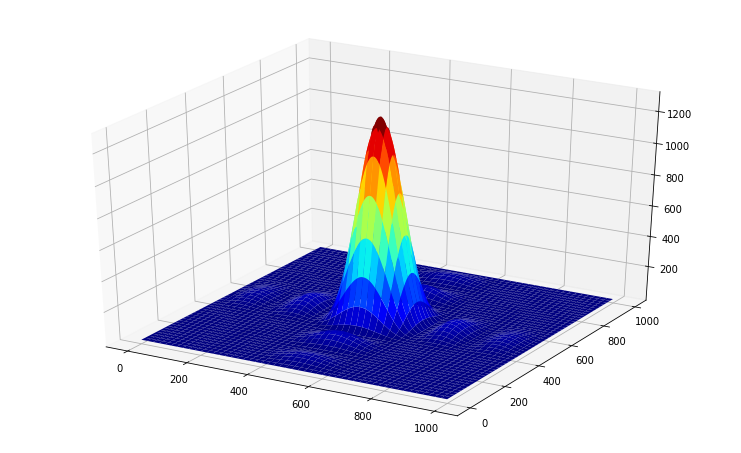

In [46]:
from mpl_toolkits.mplot3d import Axes3D
x, y = np.arange(1000), np.arange(1000)
xx, yy = np.meshgrid(x, y)
fig = plt.figure(figsize = (10, 6))
fig = Axes3D(fig)
fig.plot_surface(xx, yy, ft, cmap = 'jet')
plt.show()

下面用莱娜图得到她的傅里叶频谱

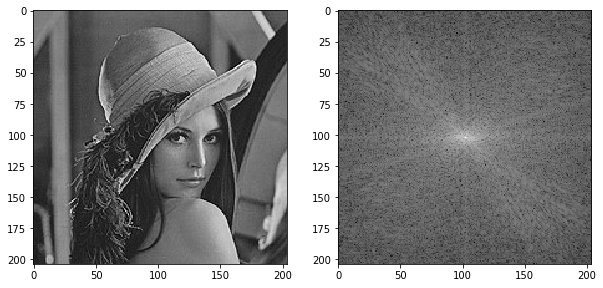

In [49]:
img = cv.imread('lena.jpg', 0)
plt.figure(figsize = (10, 5))
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.subplot(122), plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(img)))**2), cmap = 'gray')
plt.show()

那么，逆傅里叶变换的结果是什么样的呢？

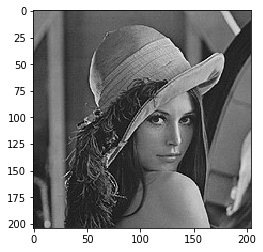

In [50]:
ft = np.fft.fft2(img)
reverse = np.fft.ifft2(ft).real
plt.imshow(reverse, cmap = 'gray')
plt.show()

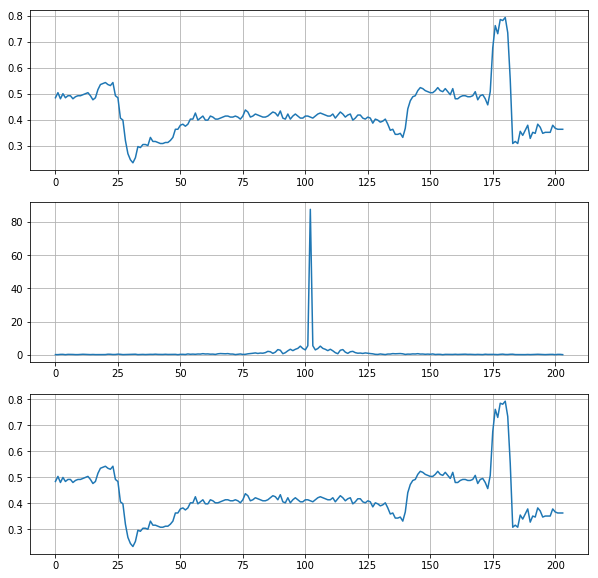

In [52]:
data = img[0, :] / 256
ft = np.fft.fft(data)
plt.figure(figsize = (10, 10))
plt.subplot(311), plt.plot(data), plt.grid(True)
plt.subplot(312), plt.plot(np.abs(np.fft.fftshift(ft))), plt.grid(True)
plt.subplot(313), plt.plot(np.fft.ifft(ft).real), plt.grid(True)
plt.show()

## 傅里叶变换的作用

傅里叶变换在信号处理中有着非常重要的作用，这是为什么？

在数学上，一个函数的傅里叶变换可以经过反变换得到原图像，而不会失去任何信息，而傅里叶变换的结果表现的是一个信号的频率组成情况，这就非常有意思了：频率的组成反映的是一个信号的整体情况，就像之前我们说到过的图像的灰度频率直方图，每一个在直方图中出现的灰度值可能散布在一张图像的任何角落，这样只要处理灰度直方图，就可以对整张图像的亮度和对比度进行调整。

同样，我们可以这样理解：组成一个信号的一种频率可能散布在一张图像的任何角落，那么，对频谱的一个小部分做归零处理或者做其他处理，就可以影响整张图像，这就是频率域上的滤波的概念来源。

## 滤波器的实现

### 理想滤波器

所谓的低通滤波器，实际上就是去除信号中的高频部分。在频率空间中，一个低通滤波器就是很简单地从原点向外辐射一块值为1的区域，而把其他部分置零。用它去和原始信号的傅里叶变换结果相乘，就可以达到滤除高频波的效果。

在频率域中的相乘看起来非常的自然，根据卷积定理可以知道，频率域中两个信号的乘积等于空间域中两个信号的卷积。所以所谓的“滤波”其实都是在空间域上的卷积。

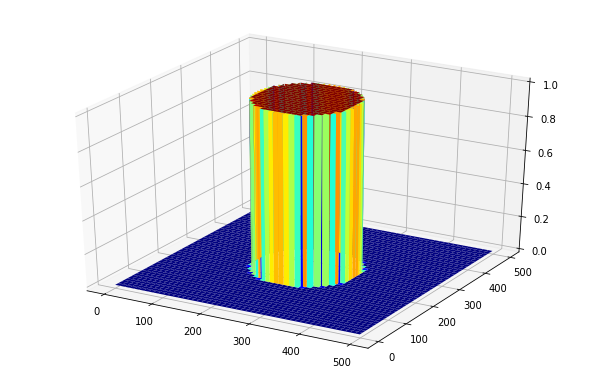

In [59]:
from mpl_toolkits.mplot3d import Axes3D
r, c = 500, 500
ILPF = np.zeros((r, c))
for i in range(r):
    for j in range(c):
        if np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j])) < 100:
            ILPF[i][j] = 1.
x, y = np.arange(r), np.arange(c)
xx, yy = np.meshgrid(x, y)
fig = plt.figure(figsize = (8, 5))
fig = Axes3D(fig)
fig.plot_surface(xx, yy, ILPF, cmap = 'jet')
plt.show()

In [45]:
img = cv.imread('lena.jpg', 0)
ft = np.fft.fftshift(np.fft.fft2(img))

In [13]:
def low_frequency_filter(pic, scale):
    r, c = pic.shape
    mat = np.zeros(pic.shape)
    mat[(r - scale) // 2 : (r + scale) // 2, (c - scale) // 2 : (c + scale) // 2] = 1.
    ft = np.fft.fftshift(np.fft.fft2(pic))
    return np.fft.ifft2(np.fft.ifftshift(ft * mat)).real

上面构造了一个方形的低通滤波器，但是这个滤波器会使输出图像具有重影

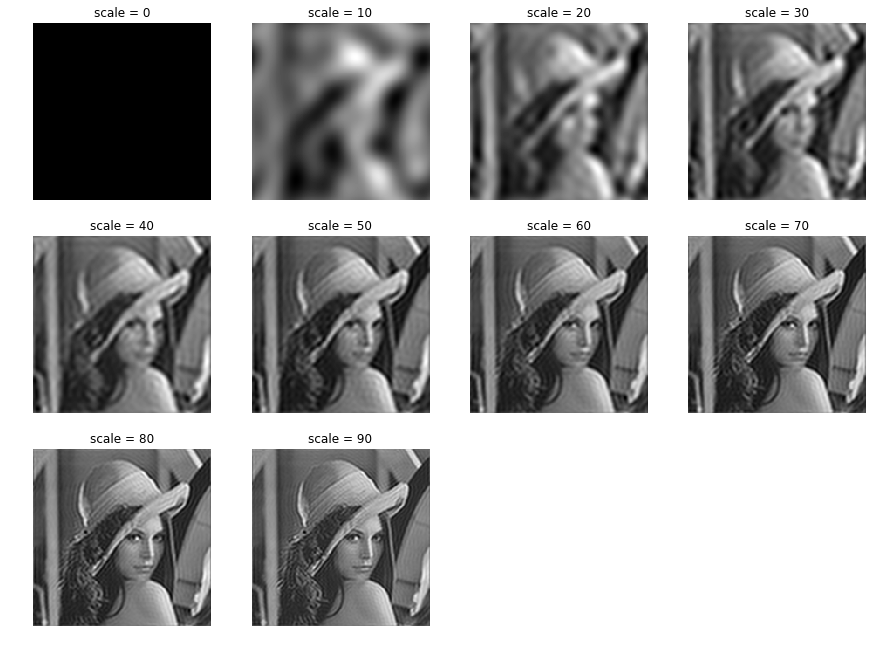

In [14]:
plt.figure(figsize = (15, 15))
for i in range(10):
    plt.subplot(4, 4, i + 1), plt.axis("off")
    plt.imshow(low_frequency_filter(img, 10 * i), cmap = 'gray')
    plt.title('scale = %d' % (10 * i))
plt.show()

In [15]:
def low_frequency_filter(pic, scale):
    r, c = pic.shape
    mat = np.zeros(pic.shape)
    for i in range(r):
        for j in range(c):
            if np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j])) < scale // 2:
                mat[i][j] = 1.
    ft = np.fft.fftshift(np.fft.fft2(pic))
    return np.fft.ifft2(np.fft.ifftshift(ft * mat)).real

换成圆形区域之后，并没有像预想的那样，让重影消失

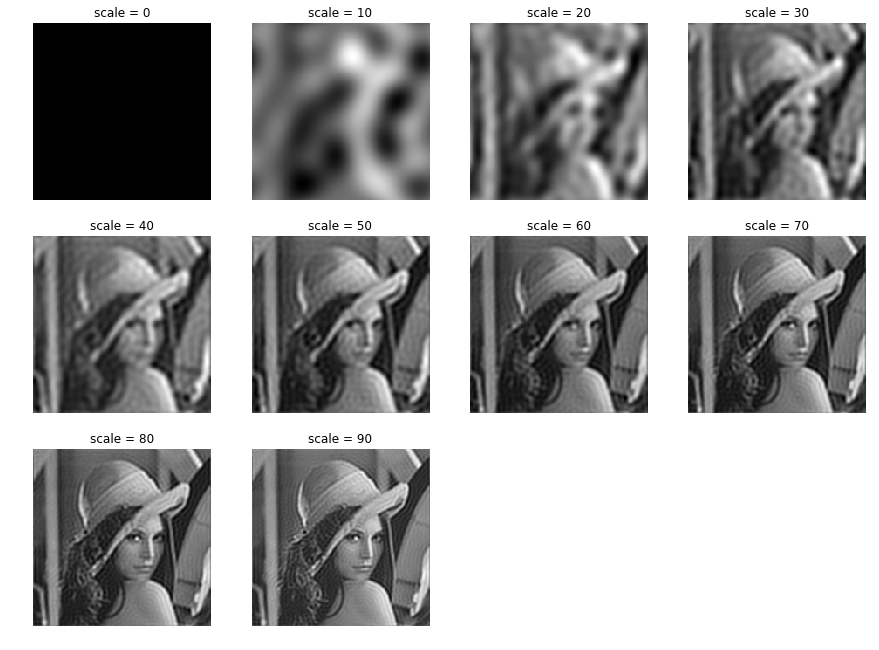

In [16]:
plt.figure(figsize = (15, 15))
for i in range(10):
    plt.subplot(4, 4, i + 1), plt.axis("off")
    plt.imshow(low_frequency_filter(img, 10 * i), cmap = 'gray')
    plt.title('scale = %d' % (10 * i))
plt.show()

高通滤波器的实现则恰好相反，低频部分的为0，高频部分为1

In [17]:
def high_frequency_filter(pic, scale):
    r, c = pic.shape
    mat = np.ones(pic.shape)
    mat[(r - scale) // 2 : (r + scale) // 2, (c - scale) // 2 : (c + scale) // 2] = 0.
    ft = np.fft.fftshift(np.fft.fft2(pic))
    return np.fft.ifft2(np.fft.ifftshift(ft * mat)).real

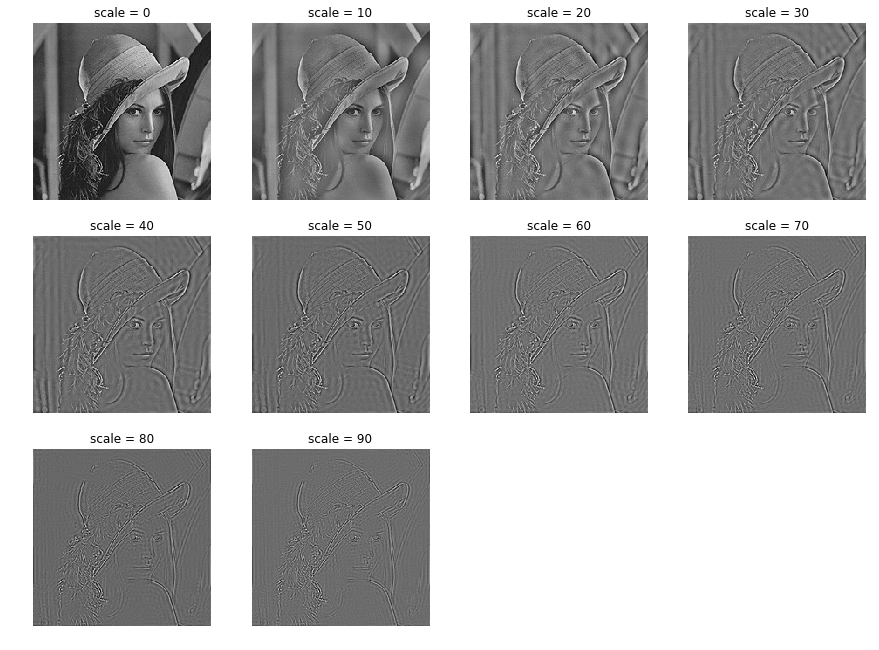

In [18]:
plt.figure(figsize = (15, 15))
for i in range(10):
    plt.subplot(4, 4, i + 1), plt.axis("off")
    plt.imshow(high_frequency_filter(img, 10 * i), cmap = 'gray')
    plt.title('scale = %d' % (10 * i))
plt.show()

结合之前的边缘检测的内容，可以想见高通滤波是可以用来找到图像中的边缘部分的（边缘就是信号中突变的部分，这些地方的信息都保留在频率域中的高频区域）。

后面经过查阅一些资料发现，这种图像上的重影叫做“振铃效应”，是理想滤波器的一个弊病。

### 高斯滤波器

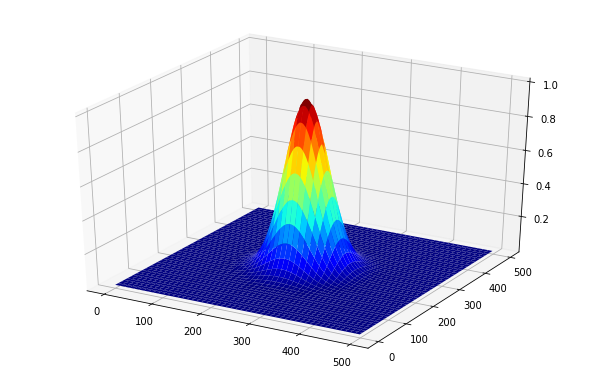

In [64]:
from mpl_toolkits.mplot3d import Axes3D
r, c = 500, 500
GLPF = np.zeros((r, c))
for i in range(r):
    for j in range(c):
        dis = np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j]))
        GLPF[i][j] = np.exp(-dis ** 2 / (2 * 40 ** 2))
x, y = np.arange(r), np.arange(c)
xx, yy = np.meshgrid(x, y)
fig = plt.figure(figsize = (8, 5))
fig = Axes3D(fig)
fig.plot_surface(xx, yy, GLPF, cmap = 'jet')
plt.show()

从上面普通滤波器的实现可以看到，不同的滤波器只是更改那个滤波函数，就此我们甚至可以开发出一个通用的函数，就像在空间域滤波时所做的那样

In [26]:
def low_guassian_filter(pic, scale):
    r, c = pic.shape
    mat = np.zeros(pic.shape)
    for i in range(r):
        for j in range(c):
            dis = np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j]))
            mat[i][j] = np.exp(-dis ** 2 / (2 * scale ** 2))
    ft = np.fft.fftshift(np.fft.fft2(pic))
    return np.fft.ifft2(np.fft.ifftshift(ft * mat)).real

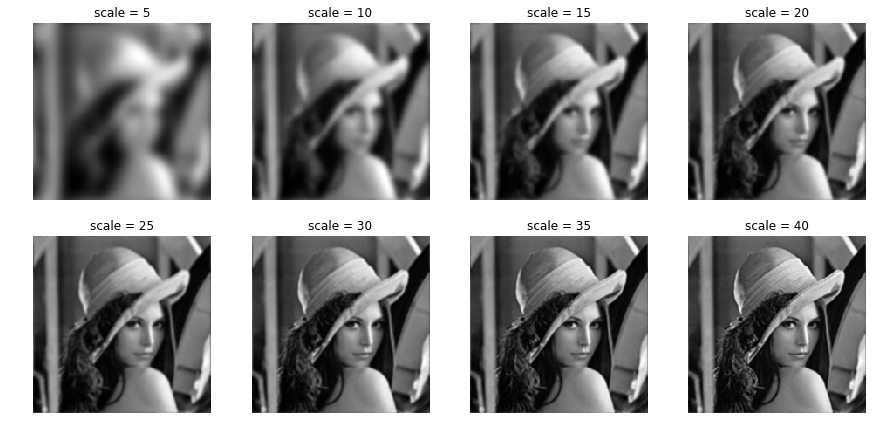

In [31]:
plt.figure(figsize = (15, 15))
for i in range(1, 9):
    plt.subplot(4, 4, i), plt.axis("off")
    plt.imshow(low_guassian_filter(img, 5 * i), cmap = 'gray')
    plt.title('scale = %d' % (5 * i))
plt.show()

In [32]:
def high_guassian_filter(pic, scale):
    r, c = pic.shape
    mat = np.zeros(pic.shape)
    for i in range(r):
        for j in range(c):
            dis = np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j]))
            mat[i][j] = 1 - np.exp(-dis ** 2 / (2 * scale ** 2))
    ft = np.fft.fftshift(np.fft.fft2(pic))
    return np.fft.ifft2(np.fft.ifftshift(ft * mat)).real

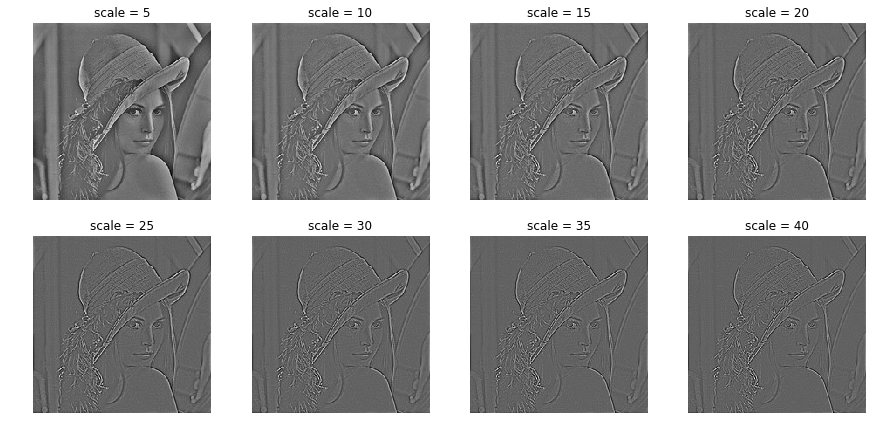

In [33]:
plt.figure(figsize = (15, 15))
for i in range(1, 9):
    plt.subplot(4, 4, i), plt.axis("off")
    plt.imshow(high_guassian_filter(img, 5 * i), cmap = 'gray')
    plt.title('scale = %d' % (5 * i))
plt.show()

可以看到，采用高斯函数的滤波器完全没有振铃效应。这其中的原因是：在频率域中的理想滤波器的傅里叶逆变换是一个sinc函数，越是接近理想滤波器的函数变换到空域的时候它的波动就越大，这就是说，它会在空域中产生一定的边际效应；但是高斯函数的傅里叶逆变换仍然是高斯函数，除中心点之外其余的地方很平滑，所以便没有振铃效应。

### 布特沃斯滤波器

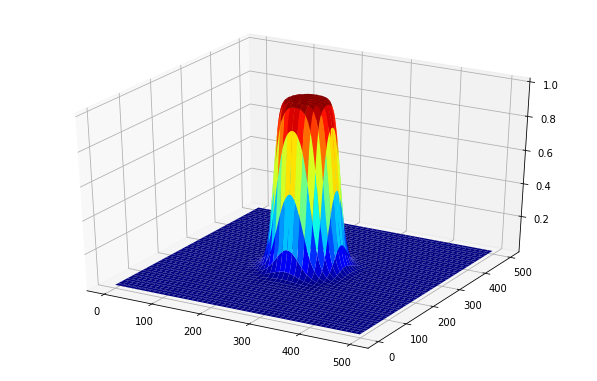

In [70]:
from mpl_toolkits.mplot3d import Axes3D
r, c = 500, 500
scale, n = 60, 5
BLPF = np.zeros((r, c))
for i in range(r):
    for j in range(c):
        dis = np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j]))
        BLPF[i][j] = 1 / (1 + (dis / scale) ** (2 * n))
x, y = np.arange(r), np.arange(c)
xx, yy = np.meshgrid(x, y)
fig = plt.figure(figsize = (8, 5))
fig = Axes3D(fig)
fig.plot_surface(xx, yy, BLPF, cmap = 'jet')
plt.show()

理想滤波器会有振铃效应，但是高斯滤波器又不能很明确地阻断高频信号，而布特沃斯滤波器结合了二者的优点，成为一种折中的滤波方法。

In [43]:
def BLPF(pic, scale, n):
    r, c = pic.shape
    mat = np.zeros(pic.shape)
    for i in range(r):
        for j in range(c):
            dis = np.linalg.norm(np.array([r // 2, c // 2]) - np.array([i, j]))
            mat[i][j] = 1 / (1 + (dis / scale) ** (2 * n))
    ft = np.fft.fftshift(np.fft.fft2(pic))
    return np.fft.ifft2(np.fft.ifftshift(ft * mat)).real

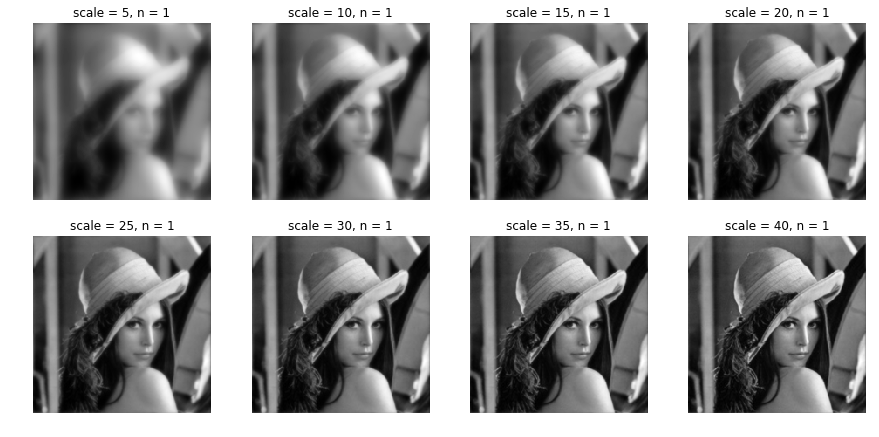

In [44]:
n = 1
plt.figure(figsize = (15, 15))
for i in range(1, 9):
    plt.subplot(4, 4, i), plt.axis("off")
    plt.imshow(BLPF(img, 5 * i, n), cmap = 'gray')
    plt.title('scale = %d, n = %d' % (5 * i, n))
plt.show()

上面的滤波效果较之高斯滤波没有很大的区别，这是因为当n较小的时候，BLPF更接近高斯函数，而当n较大的时候，它更接近理想滤波器，但是要注意，当n变大的时候，BLPF也不能避免振铃效应。

## 选择性滤波

上面提到的滤波要么是除掉高频部分，要么是除掉低频部分，但是在一张图像中，有可能需要指定一个频率范围将它保留或者去除。这样形式的滤波器就叫做**带通滤波器**。

这一部分的内容和图像复原与重建有关，需要放在下一章中介绍。